<a href="https://colab.research.google.com/github/ManGuo1130/Synergistic-effect-evaluation/blob/main/R_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torch-geometric pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.8 MB/s eta 0:00:00


# 数据准备

##处理节点数据

In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 加载节点特征
node_features = pd.read_csv("/content/drive/MyDrive/Modis/node_features.csv")
weights_all = pd.read_csv("/content/drive/MyDrive/Modis/weights_all.csv")

# 查看数据结构
print(node_features.head())
print(weights_all.head())

   Unnamed: 0   地市        lat         lon       协同度  常住人口  城市建设用地占市区.面积比重  \
0           1  安庆市  30.576049  116.486728  0.549207   417           15.68   
1           2  常州市  31.625341  119.637182  0.784272   528            9.62   
2           3  池州市  30.284429  117.365321  0.660851   134            1.61   
3           4  滁州市  32.544120  118.102548  0.739916   399            6.55   
4           5  杭州市  29.900238  119.469934  0.729286  1197            7.38   

   地区生产总值  人均地区生产总值  第二产业占地区生产总值的比重  第三产业占地区生产总值的比重  工业企业数  专利授权数  绿化覆盖率  \
0    2468     58684           43.23           47.04   1644   5479  39.49   
1    7805    147939           46.33           51.57   5065  41321  43.30   
2     869     64843           44.07           45.80    539   2374  46.13   
3    3032     76087           48.75           42.28   1870   8654  42.30   
4   16106    136617           29.93           68.04   5992  92399  43.36   

   OBJECTID  
0         1  
1         2  
2         3  
3         4  
4         

In [3]:
# 编码节点ID为整数索引
le = LabelEncoder()
node_features['ID_encoded'] = le.fit_transform(node_features['OBJECTID'])

# 创建ID到索引的映射
id_to_index = {id_: idx for idx, id_ in enumerate(node_features['OBJECTID'])}

In [4]:
print(id_to_index)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26}


In [5]:
# 准备节点特征矩阵
feature_columns = [
    '常住人口', '城市建设用地占市区.面积比重', '地区生产总值',
    '人均地区生产总值', '第二产业占地区生产总值的比重',
    '第三产业占地区生产总值的比重', '工业企业数', '专利授权数',
    '绿化覆盖率'
]

In [6]:
X = node_features[feature_columns].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float)

In [7]:
print(X)

tensor([[-0.4836,  0.5847, -0.6946, -1.5759, -0.0449, -0.6489, -0.8534, -0.9024,
         -1.5415],
        [-0.2507, -0.2169, -0.0059,  1.1647,  0.4802, -0.0193,  0.3622,  0.0792,
          0.1763],
        [-1.0775, -1.2764, -0.9010, -1.3868,  0.0974, -0.8213, -1.2461, -0.9874,
          1.4523],
        [-0.5214, -0.6230, -0.6219, -1.0415,  0.8901, -1.3106, -0.7731, -0.8154,
         -0.2745],
        [ 1.1533, -0.5132,  1.0653,  0.8171, -2.2975,  2.2701,  0.6916,  1.4780,
          0.2034],
        [ 0.6077,  3.0939,  0.2833, -0.0485, -1.3304,  1.2999, -0.6736,  0.0719,
         -0.4143],
        [-0.6515, -0.4325, -0.6001, -0.4430,  1.0357, -0.7907, -0.0902, -0.5674,
          1.5425],
        [-0.2234,  0.3069, -0.3021, -0.2293,  1.4270, -0.8171,  0.8238, -0.0949,
         -0.8967],
        [ 0.1229, -0.7923, -0.4061, -1.3105, -0.8358,  0.8884,  0.2073,  0.1100,
         -0.6172],
        [-0.9054,  0.2064, -0.7309, -0.2762,  0.7343, -0.5641, -1.0347, -0.8380,
          1.5199],


In [8]:
# 准备目标变量（协同度）
y = torch.tensor(node_features['协同度'].values, dtype=torch.float).unsqueeze(1)

print(y)

tensor([[0.5492],
        [0.7843],
        [0.6609],
        [0.7399],
        [0.7293],
        [0.6852],
        [0.7373],
        [0.7180],
        [0.7326],
        [0.7303],
        [0.8068],
        [0.7315],
        [0.7429],
        [0.8088],
        [0.7640],
        [0.7647],
        [0.7240],
        [0.7559],
        [0.7059],
        [0.6741],
        [0.7913],
        [0.7221],
        [0.7767],
        [0.7872],
        [0.7936],
        [0.7640],
        [0.8117]])


## 构建图数据结果

In [9]:
# 映射ID到索引
weights_all['from_idx'] = weights_all['from'].map(id_to_index)
weights_all['to_idx'] = weights_all['to'].map(id_to_index)

In [10]:
# 处理关系类型
relation_le = LabelEncoder()
weights_all['relation_encoded'] = relation_le.fit_transform(weights_all['relation'])

In [11]:
# 准备边索引和边类型
edge_index = torch.tensor(weights_all[['from_idx', 'to_idx']].values, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(weights_all['relation_encoded'].values, dtype=torch.long)

In [12]:
print(edge_index)

tensor([[ 0,  0,  0,  ..., 26, 26, 26],
        [ 2,  3,  4,  ..., 20, 22, 25]])


In [13]:
print(edge_type)

tensor([5, 5, 5,  ..., 2, 2, 2])


In [14]:
# 准备边权重
edge_weight = torch.tensor(weights_all['weights'].values, dtype=torch.float)

In [15]:
print(edge_weight)

tensor([2.7339e-01, 1.1664e-02, 0.0000e+00,  ..., 3.7748e-02, 1.5243e-03,
        1.6362e-04])


In [16]:
# 创建图数据对象
data = Data(x=X, edge_index=edge_index, edge_type=edge_type, edge_attr=edge_weight, y=y)

print(data)

Data(x=[27, 9], edge_index=[2, 4509], edge_attr=[4509], y=[27, 1], edge_type=[4509])


# 定义R-GCN模型

In [44]:
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim

# 自定义加权 RGCN 卷积层
class WeightedRGCNConv(RGCNConv):
    def forward(self, x, edge_index, edge_type, edge_weight=None):
        self.edge_weight = edge_weight
        return super().forward(x, edge_index, edge_type)

    def message(self, x_j, edge_weight=None):
        if edge_weight is not None:
            return x_j * edge_weight.view(-1, 1)  # 加权消息
        return x_j

In [49]:
# 定义 RGCN 模型
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = WeightedRGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = WeightedRGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type, edge_weight=None):
        # 第一层卷积
        x = self.conv1(x, edge_index, edge_type, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # 第二层卷积
        x = self.conv2(x, edge_index, edge_type, edge_weight=edge_weight)
        return x

In [47]:
print(f"data.x shape: {data.x.shape}")  # 节点特征矩阵
print(f"data.edge_index shape: {data.edge_index.shape}")  # 边索引矩阵
print(f"data.edge_type shape: {data.edge_type.shape}")  # 边类型索引
print(f"data.edge_attr shape: {data.edge_attr.shape}")  # 边权重
print(f"data.y shape: {data.y.shape}")  # 节点标签

data.x shape: torch.Size([27, 9])
data.edge_index shape: torch.Size([2, 4509])
data.edge_type shape: torch.Size([4509])
data.edge_attr shape: torch.Size([4509])
data.y shape: torch.Size([27, 1])


In [50]:
# 定义模型参数
in_channels = 9
hidden_channels = 16
out_channels = 1 # 回归任务
num_relations = len(torch.unique(data.edge_type)) # relation_le 是一个示例的关系标签编码器

In [51]:
# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

In [52]:
# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [56]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import torch.optim as optim

# 自定义加权 RGCN 卷积层
class WeightedRGCNConv(RGCNConv):
    def forward(self, x, edge_index, edge_type, edge_weight=None):
        self.edge_weight = edge_weight
        return super().forward(x, edge_index, edge_type)

    def message(self, x_j, edge_type_ptr, edge_weight=None):
        if edge_weight is not None:
            return x_j * edge_weight.view(-1, 1)  # 加权消息
        return x_j

# 定义 RGCN 模型
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super(RGCN, self).__init__()
        self.conv1 = WeightedRGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = WeightedRGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type, edge_weight=None):
        # 第一层卷积
        x = self.conv1(x, edge_index, edge_type, edge_weight=edge_weight)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # 第二层卷积
        x = self.conv2(x, edge_index, edge_type, edge_weight=edge_weight)
        return x

# 定义模型参数
in_channels = 9  # 节点特征维度
hidden_channels = 16
out_channels = 1  # 回归任务输出维度
num_relations = len(torch.unique(data.edge_type))  # 边类型数量

# 实例化模型
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

# 将模型和数据移动到设备（如果有GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# 定义损失函数和优化器
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练函数
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        # 模型调用，传入所需参数
        out = model(
            x=data.x,
            edge_index=data.edge_index,
            edge_type=data.edge_type,
            edge_weight=data.edge_attr  # 将 edge_attr 作为 edge_weight 传递
        )
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 训练模型
print("开始训练模型...")
train(model, data, optimizer, criterion, epochs=100)

开始训练模型...
Epoch 10, Loss: 2.2501
Epoch 20, Loss: 0.4326
Epoch 30, Loss: 0.1994
Epoch 40, Loss: 0.2053
Epoch 50, Loss: 0.1205
Epoch 60, Loss: 0.4176
Epoch 70, Loss: 0.2764
Epoch 80, Loss: 0.0786
Epoch 90, Loss: 0.1281
Epoch 100, Loss: 0.0265


in_channels = X.shape[1]

确定输入特征的维度。
X 是之前准备好的节点特征张量，形状为 [num_nodes, num_features]。
X.shape[1] 获取特征的维度，即num_features，作为in_channels。
hidden_channels = 16

设置隐藏层的特征维度为16。
这是一个经验性选择，可以根据数据和模型表现进行调整。
out_channels = 1 # 预测协同度

设置输出层的特征维度为1，用于回归任务中预测每个节点的协同度。
num_relations = len(relation_le.classes_)

确定关系类型的数量。
relation_le 是之前定义并拟合的LabelEncoder对象，用于编码边的关系类型。
relation_le.classes_ 返回所有的关系类型，每种关系类型对应一个唯一的类别。
len(relation_le.classes_) 计算关系类型的总数，作为RGCNConv层中num_relations的参数。
model = RGCN(in_channels, hidden_channels, out_channels, num_relations)

使用之前定义的RGCN类实例化一个R-GCN模型对象。
参数解释：
in_channels: 输入特征维度，从节点特征矩阵X中获取。
hidden_channels: 隐藏层的特征维度，设置为16。
out_channels: 输出特征维度，设置为1，用于回归任务。
num_relations: 关系类型的数量，确保模型能区分不同类型的边。


开始评估模型...
测试损失: 0.0056
均方误差 (MSE): 0.0056
决定系数 (R²): -0.8762


<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout()
<ipython-input-57-1c9b0f39b7ee>:54: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  plt.tight_layout()
<ipyth

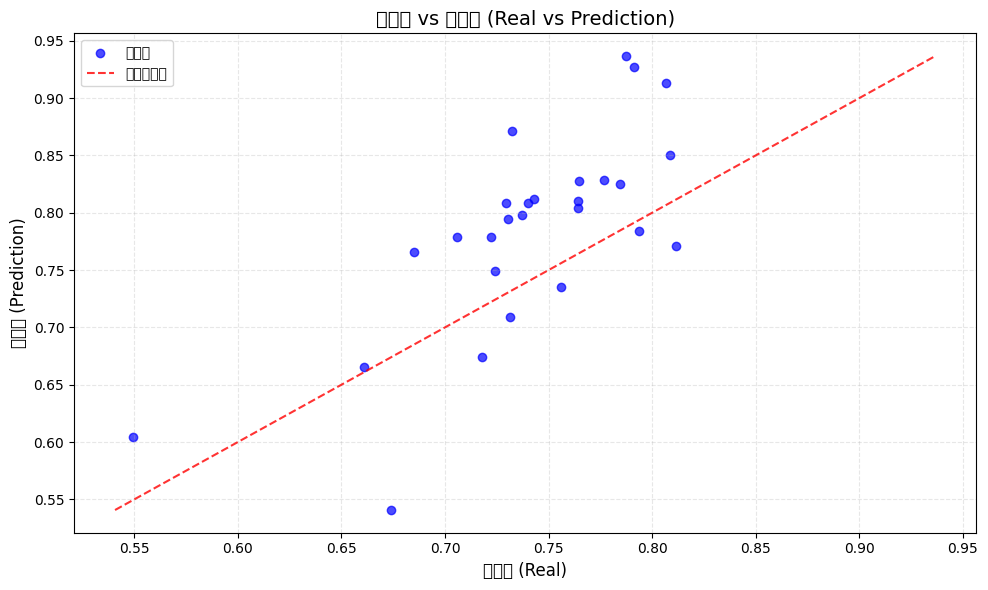


详细预测结果:
节点ID	真实值	预测值	误差
0	0.5492	0.6047	0.0555
1	0.7843	0.8255	0.0412
2	0.6609	0.6656	0.0048
3	0.7399	0.8089	0.0689
4	0.7293	0.8085	0.0792
5	0.6852	0.7654	0.0801
6	0.7373	0.7982	0.0608
7	0.7180	0.6739	0.0441
8	0.7326	0.8716	0.1390
9	0.7303	0.7942	0.0639
10	0.8068	0.9130	0.1062
11	0.7315	0.7094	0.0221
12	0.7429	0.8119	0.0690
13	0.8088	0.8504	0.0416
14	0.7640	0.8038	0.0398
15	0.7647	0.8274	0.0628
16	0.7240	0.7494	0.0254
17	0.7559	0.7354	0.0205
18	0.7059	0.7789	0.0730
19	0.6741	0.5407	0.1335
20	0.7913	0.9275	0.1362
21	0.7221	0.7788	0.0567
22	0.7767	0.8287	0.0521
23	0.7872	0.9368	0.1495
24	0.7936	0.7837	0.0099
25	0.7640	0.8106	0.0466
26	0.8117	0.7711	0.0406

模型已保存到: rgcn_model.pth


In [57]:
# 评估模型
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 评估模型
print("\n开始评估模型...")
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    # 修改模型调用，确保传入所有必要参数
    predictions = model(
        x=data.x,
        edge_index=data.edge_index,
        edge_type=data.edge_type,
        edge_weight=data.edge_attr  # 确保传入边权重
    )

    # 计算测试损失
    loss = criterion(predictions, data.y)
    print(f'测试损失: {loss.item():.4f}')

    # 转换为 NumPy 数组进行评估
    preds = predictions.cpu().detach().numpy().flatten()  # 确保从 GPU 转到 CPU
    targets = data.y.cpu().detach().numpy().flatten()

    # 计算评估指标
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'均方误差 (MSE): {mse:.4f}')
    print(f'决定系数 (R²): {r2:.4f}')

    # 可视化预测结果
    plt.figure(figsize=(10, 6))

    # 绘制散点图
    plt.scatter(targets, preds, alpha=0.7, label='预测点', color='blue')

    # 绘制对角线
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='理想预测线', alpha=0.8)

    # 添加标签和标题
    plt.xlabel('真实值 (Real)', fontsize=12)
    plt.ylabel('预测值 (Prediction)', fontsize=12)
    plt.title('真实值 vs 预测值 (Real vs Prediction)', fontsize=14)
    plt.legend(fontsize=10)

    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.3)

    # 调整布局
    plt.tight_layout()

    # 显示图像
    plt.show()

    # 输出详细的预测结果
    print("\n详细预测结果:")
    print("节点ID\t真实值\t预测值\t误差")
    for i in range(len(targets)):
        error = abs(targets[i] - preds[i])
        print(f"{i}\t{targets[i]:.4f}\t{preds[i]:.4f}\t{error:.4f}")

# 保存模型（可选）
model_path = 'rgcn_model.pth'
torch.save(model.state_dict(), model_path)
print(f"\n模型已保存到: {model_path}")

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

# 初始化解释器
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',  # 修改为 'node'
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',  # 根据您的任务类型（回归）
        task_level='node',
        return_type='raw',  # 回归任务通常使用 'raw' 输出
    ),
)

# 使用解释器
node_index = 10  # 要解释的节点
try:
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        edge_type=data.edge_type,
        node_idx=node_index  # 使用 node_idx 而不是 target
    )
    print(f'Generated explanations in {explanation.available_explanations}')

    # 打印解释对象的属性
    print("\n解释对象的属性：")
    for attr in dir(explanation):
        if not attr.startswith('_'):
            value = getattr(explanation, attr)
            if isinstance(value, (torch.Tensor,)):
                print(f"{attr}: shape = {value.shape}")
            else:
                print(f"{attr}: {type(value)}")

except Exception as e:
    print(f"发生错误: {str(e)}")
    import traceback
    traceback.print_exc()

发生错误: 


Traceback (most recent call last):
  File "<ipython-input-85-6535741fa928>", line 20, in <cell line: 19>
    explanation = explainer(
  File "/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py", line 196, in __call__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py", line 115, in get_prediction
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-76-b7e5cbee5b27>", line 18, in forward
    x = self.conv1(x, edge_index, edge_type)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrappe

In [ ]:
print(f"data.x shape: {data.x.shape}")
print(f"data.edge_index shape: {data.edge_index.shape}")
print(f"data.edge_type shape: {data.edge_type.shape}")
print(f"data.edge_attr shape: {data.edge_attr.shape if hasattr(data, 'edge_attr') else '无'}")
print(f"data.y shape: {data.y.shape}")

data.x shape: torch.Size([27, 9])
data.edge_index shape: torch.Size([2, 4509])
data.edge_type shape: torch.Size([4509])
data.edge_attr shape: torch.Size([4509])
data.y shape: torch.Size([27, 1])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# 在训练和解释时确保数据与模型在同一设备上
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        out = model(
            x=data.x,
            edge_index=data.edge_index,
            edge_type=data.edge_type,
            edge_attr=data.edge_attr
        )
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 训练模型

In [ ]:

# 评估模型
print("\n开始评估模型...")
model.eval()
with torch.no_grad():
    # 修改模型调用，确保传入所有必要参数
    predictions = model(
        x=data.x,
        edge_index=data.edge_index,
        edge_type=data.edge_type,
        edge_attr=data.edge_attr
    )
    loss = criterion(predictions, data.y)
    print(f'测试损失: {loss.item():.4f}')

    # 转换为numpy数组进行评估
    preds = predictions.detach().numpy().flatten()
    targets = data.y.detach().numpy().flatten()

    # 计算评估指标
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'均方误差 (MSE): {mse:.4f}')
    print(f'决定系数 (R²): {r2:.4f}')

    # 可视化预测结果
    plt.figure(figsize=(10, 6))

    # 绘制散点图
    plt.scatter(targets, preds, alpha=0.7, label='预测点')

    # 绘制对角线
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', label='理想预测线', alpha=0.8)

    # 添加标签和标题
    plt.xlabel('real', fontsize=12)
    plt.ylabel('prediction', fontsize=12)
    plt.title('real vs prediction', fontsize=14)
    plt.legend(fontsize=10)

    # 添加网格
    plt.grid(True, linestyle='--', alpha=0.3)

    # 调整布局
    plt.tight_layout()

    # 显示图像
    plt.show()

    # 输出详细的预测结果
    print("\n详细预测结果:")
    print("节点ID\t真实值\t预测值\t误差")
    for i in range(len(targets)):
        error = abs(targets[i] - preds[i])
        print(f"{i}\t{targets[i]:.4f}\t{preds[i]:.4f}\t{error:.4f}")

# 保存模型（可选）
torch.save(model.state_dict(), 'rgcn_model.pth')


开始评估模型...


AssertionError: 

成功使用字体: SimHei


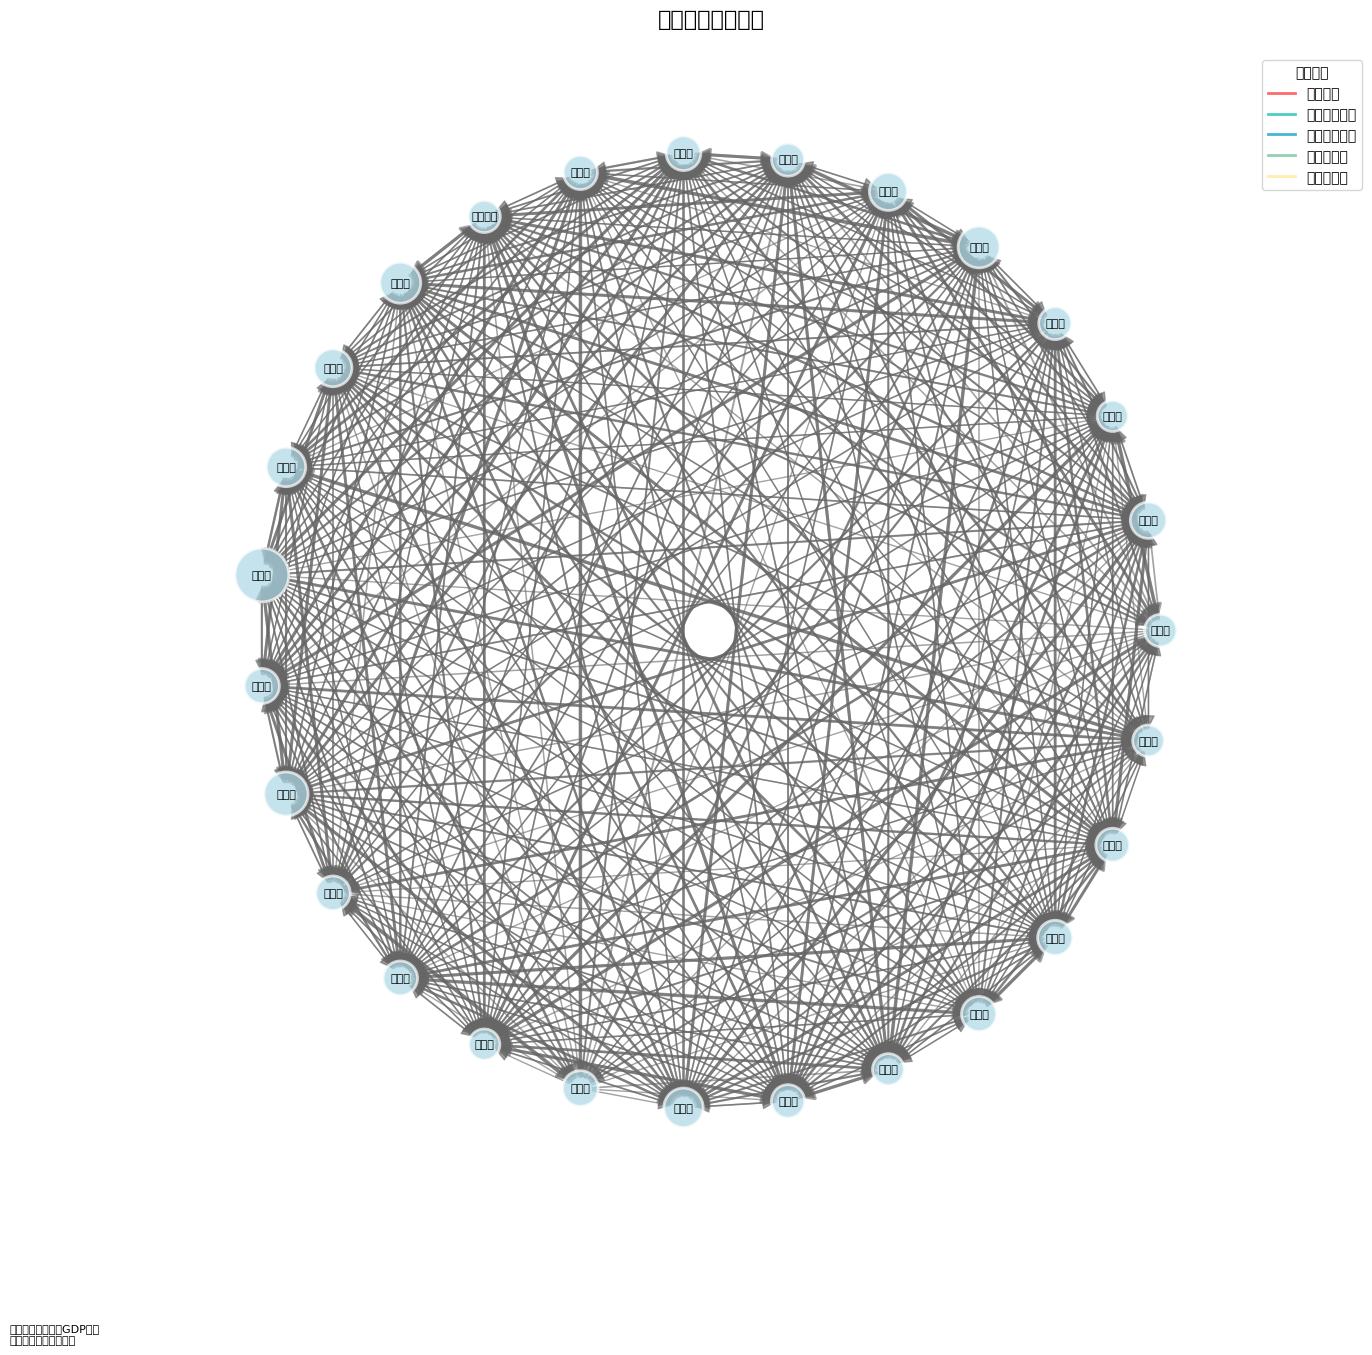


网络统计信息：
节点数量: 27
边的数量: 648
平均度: 48.00
网络密度: 0.9231

重要节点分析：

度中心性最高的5个城市：
常州市: 1.9231
杭州市: 1.9231
湖州市: 1.9231
嘉兴市: 1.9231
金华市: 1.9231

接近中心性最高的5个城市：
常州市: 1.0000
杭州市: 1.0000
湖州市: 1.0000
嘉兴市: 1.0000
金华市: 1.0000

介数中心性最高的5个城市：
金华市: 0.0058
池州市: 0.0052
上海市: 0.0046
杭州市: 0.0043
嘉兴市: 0.0043


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# 设置中文字体
def set_chinese_font():
    try:
        # 尝试使用系统自带的中文字体
        fonts = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'NSimSun', 'AR PL UMing CN']
        for font in fonts:
            try:
                plt.rcParams['font.sans-serif'] = [font]
                plt.rcParams['axes.unicode_minus'] = False
                # 测试是否可以显示中文
                plt.figure(figsize=(1,1))
                plt.text(0.5, 0.5, '测试')
                plt.close()
                print(f"成功使用字体: {font}")
                return True
            except:
                continue

        # 如果系统字体都不可用，使用matplotlib自带的DejaVu Sans
        plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
        plt.rcParams['axes.unicode_minus'] = False
        return False
    except:
        return False

def create_network_visualization(node_features, weights_all):
    # 设置中文字体
    chinese_font_available = set_chinese_font()

    # 创建有向图
    G = nx.DiGraph()

    # 添加节点，附加特征
    for idx, row in node_features.iterrows():
        # 计算节点大小（基于GDP标准化）
        gdp_normalized = (row['地区生产总值'] - node_features['地区生产总值'].min()) / \
                        (node_features['地区生产总值'].max() - node_features['地区生产总值'].min())
        node_size = 1000 * (gdp_normalized + 0.5)

        G.add_node(row['OBJECTID'],
                  area=row['城市建设用地占市区.面积比重'],
                  gdp=row['地区生产总值'],
                  coord=(row.get('lat', 0), row.get('lon', 0)),
                  name=row.get('地市', f'City_{row["OBJECTID"]}'),
                  node_size=node_size)

    # 添加边
    for idx, row in weights_all.iterrows():
        normalized_weight = (row['weights'] - weights_all['weights'].min()) / \
                          (weights_all['weights'].max() - weights_all['weights'].min())
        G.add_edge(row['from'], row['to'],
                  relation=row['relation'],
                  weight=row['weights'],
                  width=1 + 3 * normalized_weight)

    # 创建图形
    plt.figure(figsize=(15, 15))

    # 使用Kamada-Kawai布局
    pos = nx.kamada_kawai_layout(G)

    # 定义关系类型到颜色的映射
    relation_colors = {
        '常住人口': '#FF6B6B',
        '人均生产总值': '#4ECDC4',
        '地区生产总值': '#45B7D1',
        '专利授权数': '#96CEB4',
        '工业企业数': '#FFEEAD'
    }

    # 获取边的属性
    edge_colors = [relation_colors.get(data['relation'], '#666666') for _, _, data in G.edges(data=True)]
    edge_widths = [data['width'] for _, _, data in G.edges(data=True)]
    node_sizes = [G.nodes[node]['node_size'] for node in G.nodes()]

    # 绘制边
    nx.draw_networkx_edges(G, pos,
                          edge_color=edge_colors,
                          width=edge_widths,
                          alpha=0.6,
                          arrowsize=20)

    # 绘制节点
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color='lightblue',
                                 alpha=0.7,
                                 edgecolors='white',
                                 linewidths=2)

    # 添加节点标签
    labels = nx.get_node_attributes(G, 'name')
    nx.draw_networkx_labels(G, pos, labels,
                          font_size=8,
                          font_weight='bold')

    # 添加图例
    legend_elements = [plt.Line2D([0], [0], color=color, label=relation, linewidth=2)
                      for relation, color in relation_colors.items()]
    plt.legend(handles=legend_elements,
              loc='upper left',
              bbox_to_anchor=(1, 1),
              title='关系类型',
              fontsize=10)

    # 设置标题和布局
    plt.title('城市间关系网络图',
             fontsize=16,
             fontweight='bold',
             pad=20)

    # 调整布局
    plt.subplots_adjust(right=0.85)
    plt.axis('off')

    # 添加说明文字
    plt.figtext(0.02, 0.02,
                "注：节点大小表示GDP规模\n边的粗细表示关系强度",
                fontsize=8)

    return G, plt

# 创建可视化
G, plt = create_network_visualization(node_features, weights_all)

# 显示图形
plt.show()

# 输出网络统计信息
print("\n网络统计信息：")
print(f"节点数量: {G.number_of_nodes()}")
print(f"边的数量: {G.number_of_edges()}")
print(f"平均度: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"网络密度: {nx.density(G):.4f}")

# 计算中心性指标
print("\n重要节点分析：")
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# 获取节点名称
node_names = nx.get_node_attributes(G, 'name')

# 显示重要节点
print("\n度中心性最高的5个城市：")
for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node_names.get(node, node)}: {centrality:.4f}")

print("\n接近中心性最高的5个城市：")
for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node_names.get(node, node)}: {centrality:.4f}")

print("\n介数中心性最高的5个城市：")
for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node_names.get(node, node)}: {centrality:.4f}")

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data

# 假设模型和数据已经定义如下
# model = RGCN(in_channels, hidden_channels, out_channels, num_relations)
# data = Data(x=X, edge_index=edge_index, edge_type=edge_type, edge_attr=edge_weight, y=y)

# 加载训练好的模型参数（如果已保存）
# model.load_state_dict(torch.load('rgcn_model.pth'))
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

In [ ]:
#!pip uninstall torch_geometric -y
#!pip install torch-geometric==<2.6.1>

Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `pip install torch-geometric==<2.6.1>'


In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

# 确保模型处于评估模式
model.eval()

# 数据预处理
print("数据检查:")
print(f"X shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge type shape: {data.edge_type.shape}")

# 确保数据类型正确
data.x = data.x.float()
data.edge_index = data.edge_index.long()
data.edge_type = data.edge_type.long()

# 创建解释器，修改配置
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(
        epochs=100,
        lr=0.01,
        num_hops=1
    ),
    explanation_type='model',  # 改为 'prediction' 而不是 'model'
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw'
    )
)

# 选择要解释的节点
node_idx = 10

try:
    # 生成解释
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        edge_type=data.edge_type,
        target=node_idx,  # 现在可以使用target参数
    )

    # 获取解释结果
    node_mask = explanation.node_mask
    edge_mask = explanation.edge_mask

    print("\n解释生成成功!")
    print(f"节点掩码形状: {node_mask.shape}")
    print(f"边掩码形状: {edge_mask.shape}")

    # 分析特征重要性
    print("\n特征重要性分析:")
    feature_importance = node_mask.detach().numpy()
    for i, importance in enumerate(feature_importance):
        print(f"特征 {i}: {importance:.4f}")

    # 分析边的重要性
    print("\n重要边分析:")
    edge_importance = edge_mask.detach().numpy()
    significant_edges = []
    for i, importance in enumerate(edge_importance):
        if importance > 0.3:  # 设置阈值为0.3
            from_node = data.edge_index[0][i].item()
            to_node = data.edge_index[1][i].item()
            significant_edges.append((from_node, to_node, importance))

    # 按重要性排序
    significant_edges.sort(key=lambda x: x[2], reverse=True)

    # 打印前10个最重要的边
    print("\n前10个最重要的边:")
    for from_node, to_node, importance in significant_edges[:10]:
        print(f"边 {from_node}->{to_node}: {importance:.4f}")

    # 改进的可视化函数
    def visualize_explanation(explanation, data, node_idx):
        G = nx.Graph()

        # 添加节点
        for i in range(data.x.size(0)):
            G.add_node(i)

        # 添加边
        edge_index = data.edge_index.cpu().numpy()
        edge_weights = edge_mask.cpu().detach().numpy()

        # 只添加重要性大于阈值的边
        threshold = 0.2
        for i in range(edge_index.shape[1]):
            if edge_weights[i] > threshold:
                G.add_edge(
                    edge_index[0][i],
                    edge_index[1][i],
                    weight=edge_weights[i]
                )

        # 获取与目标节点相关的子图
        connected_nodes = set([node_idx])
        for edge in G.edges():
            if node_idx in edge:
                connected_nodes.add(edge[0])
                connected_nodes.add(edge[1])
        subgraph = G.subgraph(connected_nodes)

        # 使用spring_layout
        pos = nx.spring_layout(subgraph, k=1, iterations=50)

        plt.figure(figsize=(12, 12))

        # 绘制边
        edges = nx.draw_networkx_edges(
            subgraph, pos,
            edge_color=[subgraph[u][v]['weight'] for u, v in subgraph.edges()],
            edge_cmap=plt.cm.RdYlBu_r,
            width=3,
            edge_vmin=0,
            edge_vmax=1
        )

        # 绘制节点
        node_colors = ['red' if n == node_idx else 'lightblue' for n in subgraph.nodes()]
        node_sizes = [1000 if n == node_idx else 500 for n in subgraph.nodes()]

        nodes = nx.draw_networkx_nodes(
            subgraph, pos,
            node_color=node_colors,
            node_size=node_sizes,
            alpha=0.8
        )

        # 添加节点标签
        labels = {n: str(n) for n in subgraph.nodes()}
        nx.draw_networkx_labels(subgraph, pos, labels, font_size=10)

        # 添加颜色条
        plt.colorbar(edges, label='边的重要性')

        plt.title(f"节点 {node_idx} 的局部解释", pad=20)
        plt.axis('off')

        # 添加图例
        plt.legend(['目标节点', '相关节点'],
                  loc='upper left',
                  bbox_to_anchor=(1, 1))

        plt.tight_layout()
        plt.show()

    # 可视化解释结果
    visualize_explanation(explanation, data, node_idx)

    # 输出统计信息
    print("\n统计信息:")
    print(f"平均边重要性: {edge_mask.mean().item():.4f}")
    print(f"最大边重要性: {edge_mask.max().item():.4f}")
    print(f"最小边重要性: {edge_mask.min().item():.4f}")
    print(f"重要边的数量 (>0.3): {(edge_mask > 0.3).sum().item()}")

except Exception as e:
    print(f"错误: {str(e)}")
    print("\n详细信息:")
    print("模型结构:")
    print(model)
    print("\n数据结构:")
    for key in dir(data):
        if not key.startswith('_'):
            try:
                value = getattr(data, key)
                if torch.is_tensor(value):
                    print(f"{key}: {value.shape}")
            except:
                continue

数据检查:
X shape: torch.Size([27, 9])
Edge index shape: torch.Size([2, 4509])
Edge type shape: torch.Size([4509])
错误: 

详细信息:
模型结构:
RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

数据结构:
edge_attr: torch.Size([4509])
edge_index: torch.Size([2, 4509])
x: torch.Size([27, 9])
y: torch.Size([27, 1])


In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 确保模型处于评估模式
model.eval()

print("数据检查:")
print(f"X shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge type shape: {data.edge_type.shape}")

# 选择要解释的节点
node_idx = 10

try:
    # 创建解释器
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(
            epochs=100,
            lr=0.01,
            num_hops=1
        ),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config={
            'mode': 'regression',
            'task_level': 'node',
            'return_type': 'raw'
        }
    )

    # 生成解释
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        edge_type=data.edge_type,
        target=node_idx,
        index=node_idx  # 添加index参数
    )

    # 获取掩码
    node_feat_mask = explanation.node_mask
    edge_mask = explanation.edge_mask

    print("\n解释生成成功!")
    print(f"节点特征掩码形状: {node_feat_mask.shape if node_feat_mask is not None else 'None'}")
    print(f"边掩码形状: {edge_mask.shape if edge_mask is not None else 'None'}")

    # 分析特征重要性
    if node_feat_mask is not None:
        print("\n特征重要性分析:")
        feature_importance = node_feat_mask.detach().numpy()
        for i, importance in enumerate(feature_importance):
            print(f"特征 {i}: {importance:.4f}")

    # 分析边的重要性
    if edge_mask is not None:
        print("\n重要边分析:")
        edge_importance = edge_mask.detach().numpy()
        significant_edges = []

        # 获取前K个最重要的边
        K = 20  # 可以调整这个值
        top_k_indices = np.argsort(edge_importance)[-K:]

        for idx in top_k_indices:
            from_node = data.edge_index[0][idx].item()
            to_node = data.edge_index[1][idx].item()
            importance = edge_importance[idx]
            significant_edges.append((from_node, to_node, importance))

        # 按重要性排序
        significant_edges.sort(key=lambda x: x[2], reverse=True)

        print("\n最重要的边:")
        for from_node, to_node, importance in significant_edges:
            print(f"边 {from_node}->{to_node}: {importance:.4f}")

    def visualize_node_explanation(node_idx, edge_index, edge_mask, n_nodes):
        # 创建一个新的图
        G = nx.Graph()

        # 添加所有节点
        for i in range(n_nodes):
            G.add_node(i)

        # 获取与目标节点相关的边
        edge_index = edge_index.cpu().numpy()
        edge_mask = edge_mask.detach().cpu().numpy()

        # 只添加与目标节点相关的边
        relevant_edges = []
        for i in range(edge_index.shape[1]):
            if edge_index[0, i] == node_idx or edge_index[1, i] == node_idx:
                relevant_edges.append((
                    edge_index[0, i],
                    edge_index[1, i],
                    edge_mask[i]
                ))

        # 按重要性排序并只保留前N个最重要的边
        relevant_edges.sort(key=lambda x: x[2], reverse=True)
        top_n = 10  # 可以调整这个值
        relevant_edges = relevant_edges[:top_n]

        # 添加边到图中
        for from_node, to_node, importance in relevant_edges:
            G.add_edge(from_node, to_node, weight=importance)

        # 获取所有相关节点
        connected_nodes = set([node_idx])
        for edge in G.edges():
            connected_nodes.add(edge[0])
            connected_nodes.add(edge[1])

        # 创建子图
        subgraph = G.subgraph(connected_nodes)

        # 绘制图
        plt.figure(figsize=(12, 12))

        # 使用spring布局
        pos = nx.spring_layout(subgraph, k=2)

        # 绘制边
        if len(subgraph.edges()) > 0:
            edges = nx.draw_networkx_edges(
                subgraph, pos,
                edge_color=[subgraph[u][v]['weight'] for u, v in subgraph.edges()],
                edge_cmap=plt.cm.RdYlBu_r,
                width=4,
                edge_vmin=0,
                edge_vmax=max(edge_mask)
            )

            # 添加颜色条
            plt.colorbar(edges, label='Edge Importance')

        # 绘制节点
        node_colors = ['red' if n == node_idx else 'lightblue' for n in subgraph.nodes()]
        node_sizes = [1000 if n == node_idx else 500 for n in subgraph.nodes()]

        nx.draw_networkx_nodes(
            subgraph, pos,
            node_color=node_colors,
            node_size=node_sizes
        )

        # 添加节点标签
        nx.draw_networkx_labels(subgraph, pos)

        plt.title(f'Node {node_idx} Explanation')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return G

    if edge_mask is not None:
        # 可视化解释结果
        G = visualize_node_explanation(
            node_idx,
            data.edge_index,
            edge_mask,
            data.x.size(0)
        )

        # 计算一些网络统计信息
        print("\n网络统计信息:")
        print(f"平均边重要性: {edge_mask.mean().item():.4f}")
        print(f"最大边重要性: {edge_mask.max().item():.4f}")
        print(f"最小边重要性: {edge_mask.min().item():.4f}")

        # 计算节点的局部聚类系数
        try:
            local_clustering = nx.clustering(G)
            if node_idx in local_clustering:
                print(f"目标节点的局部聚类系数: {local_clustering[node_idx]:.4f}")
        except:
            print("无法计算局部聚类系数")

        # 计算中心性指标
        try:
            degree_centrality = nx.degree_centrality(G)
            if node_idx in degree_centrality:
                print(f"目标节点的度中心性: {degree_centrality[node_idx]:.4f}")
        except:
            print("无法计算度中心性")

except Exception as e:
    print(f"错误: {str(e)}")
    print("\n详细堆栈跟踪:")
    import traceback
    traceback.print_exc()

    # 打印更多调试信息
    print("\n模型信息:")
    print(model)
    print("\n数据信息:")
    for name, value in data:
        if torch.is_tensor(value):
            print(f"{name}: {value.shape}")

数据检查:
X shape: torch.Size([27, 9])
Edge index shape: torch.Size([2, 4509])
Edge type shape: torch.Size([4509])
错误: 

详细堆栈跟踪:

模型信息:
RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

数据信息:
x: torch.Size([27, 9])
edge_index: torch.Size([2, 4509])
edge_attr: torch.Size([4509])
y: torch.Size([27, 1])
edge_type: torch.Size([4509])


Traceback (most recent call last):
  File "<ipython-input-67-c69900c73261>", line 39, in <cell line: 19>
    explanation = explainer(
  File "/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py", line 196, in __call__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py", line 115, in get_prediction
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-55-425475eb75fd>", line 8, in forward
    x = self.conv1(x, edge_index, edge_type)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped

In [ ]:
import torch
from torch_geometric.explain import Explainer, GNNExplainer

# 确保模型处于评估模式
model.eval()

# 创建解释器
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(
        epochs=200,
        lr=0.01,
        num_hops=2  # 考虑2跳邻居
    ),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw'
    )
)


In [ ]:
# 创建GNNExplainer对象
# explainer = GNNExplainer(model, epochs=200)

# 选择要解释的节点（例如节点索引0）
node_idx = 0

# 生成解释
node_feat_mask, edge_mask = explainer.explain_node(
    node_idx,
    data.x,
    data.edge_index,
    edge_type=data.edge_type
)

# 打印重要的特征
print("重要特征权重:")
print(node_feat_mask)

# 打印重要的边
print("重要边权重:")
print(edge_mask)

In [ ]:
import matplotlib.pyplot as plt

# 获取特征名称（假设feature_columns已定义）
feature_columns = [
    '常住人口', '城市建设用地占市区.面积比重', '地区生产总值',
    '人均地区生产总值', '第二产业占地区生产总值比重',
    '第三产业占地区生产总值比重', '工业企业数', '专利授权数',
    '绿化覆盖率'
]

# 绘制特征重要性
plt.figure(figsize=(10, 6))
plt.bar(feature_columns, node_feat_mask.detach().numpy())
plt.xlabel('特征')
plt.ylabel('重要性权重')
plt.title(f'节点 {node_idx} 的特征重要性')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import networkx as nx
import numpy as np

# 获取解释的边掩码
edge_mask = edge_mask.detach().numpy()

# 创建NetworkX图
G = nx.Graph()
edges = data.edge_index.numpy().T
G.add_edges_from(edges)

# 选择边的颜色和宽度基于掩码
edge_colors = ['red' if edge_mask[i] > np.median(edge_mask) else 'gray' for i in range(len(edge_mask))]
edge_widths = [2 if edge_mask[i] > np.median(edge_mask) else 0.5 for i in range(len(edge_mask))]

# 设置节点颜色（突出目标节点）
node_colors = ['skyblue' if i != node_idx else 'orange' for i in range(data.num_nodes)]

# 绘制图
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f'节点 {node_idx} 的重要边网络图')
plt.axis('off')
plt.show()

In [ ]:
# 选择要解释的多个节点（例如前5个节点）
nodes_to_explain = [0, 1, 2, 3, 4]

for node_idx in nodes_to_explain:
    print(f"\n解释节点 {node_idx} 的预测:")

    # 生成解释
    node_feat_mask, edge_mask = explainer.explain_node(
        node_idx,
        data.x,
        data.edge_index,
        edge_type=data.edge_type
    )

    # 可视化特征重要性
    plt.figure(figsize=(10, 6))
    plt.bar(feature_columns, node_feat_mask.detach().numpy())
    plt.xlabel('特征')
    plt.ylabel('重要性权重')
    plt.title(f'节点 {node_idx} 的特征重要性')
    plt.xticks(rotation=45)
    plt.show()

    # 可视化重要边
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)

    edge_colors = ['red' if edge_mask[i] > np.median(edge_mask) else 'gray' for i in range(len(edge_mask))]
    edge_widths = [2 if edge_mask[i] > np.median(edge_mask) else 0.5 for i in range(len(edge_mask))]

    node_colors = ['skyblue' if i != node_idx else 'orange' for i in range(data.num_nodes)]

    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f'节点 {node_idx} 的重要边网络图')
    plt.axis('off')
    plt.show()

## 数据集划分

In [ ]:
# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 获取节点数量
num_nodes = data.num_nodes

# 定义划分比例
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [ ]:
# 确认比例总和为1
assert train_ratio + val_ratio + test_ratio == 1.0, "划分比例之和必须为1.0"

In [ ]:
train_ratio + val_ratio + test_ratio

In [ ]:
# 生成随机索引
indices = np.random.permutation(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# 创建掩码
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# 将掩码添加到数据对象中
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"训练集节点数: {train_mask.sum().item()}")
print(f"验证集节点数: {val_mask.sum().item()}")
print(f"测试集节点数: {test_mask.sum().item()}")

In [ ]:
def train(model, data, optimizer, criterion, epochs=100):
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        # 前向传播
        out = model(data)

        # 仅计算训练集的损失
        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        # 反向传播
        loss.backward()
        optimizer.step()

        # 计算验证集损失
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])

        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        # 保存最佳模型
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_rgcn_model.pth')
            print(f'最佳模型参数已保存 (Val Loss: {best_val_loss:.4f})')

    print("训练完成。")

In [ ]:
train(model, data, optimizer, criterion, epochs=500)

# 评估模型

In [ ]:
# 加载最佳模型参数
model.load_state_dict(torch.load('best_rgcn_model.pth'))
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

Test Loss: 0.1056
Test MSE: 0.1056, Test R²: -52.5262


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21327 (\N{CJK UNIFIED IDEOGRAPH-534F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

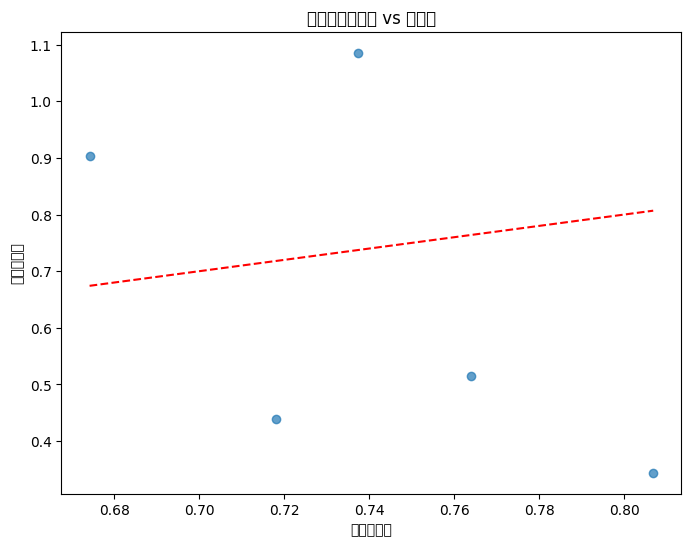

In [ ]:
with torch.no_grad():
    predictions = model(data)

    # 损失计算
    test_loss = criterion(predictions[data.test_mask], data.y[data.test_mask])
    print(f'Test Loss: {test_loss.item():.4f}')

    # 转换为numpy数组
    preds = predictions[data.test_mask].numpy().flatten()
    targets = data.y[data.test_mask].numpy().flatten()

    # 计算MSE和R²
    mse = mean_squared_error(targets, preds)
    r2 = r2_score(targets, preds)
    print(f'Test MSE: {mse:.4f}, Test R²: {r2:.4f}')

    # 绘制真实值与预测值对比
    plt.figure(figsize=(8,6))
    plt.scatter(targets, preds, alpha=0.7)
    plt.xlabel('真实协同度')
    plt.ylabel('预测协同度')
    plt.title('测试集：真实值 vs 预测值')
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.show()

# 可解释性说明

In [ ]:
import torch
from torch_geometric.explain import GNNExplainer, Explanation
from torch_geometric.explain.config import (
    ModelConfig,
    ExplainerConfig,
    MaskType
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# 配置模型
model_config = ModelConfig(
    mode='regression',  # 因为是回归任务
    task_level='node',  # 节点级任务
    return_type='raw'   # 返回原始输出
)

# 配置解释器
explainer_config = ExplainerConfig(
    explanation_type='model',  # 直接使用字符串
    node_mask_type='attributes',  # 直接使用字符串
    edge_mask_type='object'      # 直接使用字符串
)

# 初始化解释器
explainer = GNNExplainer(
    model=model,
    epochs=100,
    lr=0.01
)

# 连接配置
explainer.connect(
    model_config=model_config,
    explainer_config=explainer_config
)


In [ ]:
explainer = GNNExplainer(
    model=model,
    epochs=100,
    lr=0.01
)

In [ ]:
def analyze_node(node_idx):
    """分析单个节点的可解释性"""
    # 生成解释
    explanation = explainer(
        x=data.x,
        edge_index=data.edge_index,
        target=node_idx,
        model=model,
        edge_type=data.edge_type
    )

    # 打印解释对象的属性
    print("解释对象包含的属性：")
    for attr in dir(explanation):
        if not attr.startswith('_'):
            value = getattr(explanation, attr)
            if isinstance(value, (torch.Tensor, np.ndarray)):
                print(f"{attr}: shape = {value.shape}")
            else:
                print(f"{attr}: {type(value)}")

    return explanation

def visualize_explanation(explanation, node_idx, feature_names):
    """可视化解释结果"""
    # 1. 特征重要性可视化
    if hasattr(explanation, 'node_mask'):
        plt.figure(figsize=(10, 6))
        feature_imp = explanation.node_mask.detach().cpu().numpy()
        if len(feature_imp.shape) > 1:
            feature_imp = feature_imp[node_idx]

        # 归一化特征重要性
        feature_imp = (feature_imp - feature_imp.min()) / (feature_imp.max() - feature_imp.min())

        plt.bar(feature_names, feature_imp)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'节点 {node_idx} 的特征重要性')
        plt.tight_layout()
        plt.show()

    # 2. 边重要性可视化
    if hasattr(explanation, 'edge_mask'):
        edge_mask = explanation.edge_mask.detach().cpu().numpy()

        G = nx.Graph()
        edge_index = data.edge_index.cpu().numpy()

        # 添加边
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i], edge_index[1, i]
            G.add_edge(int(src), int(dst))

        # 设置布局
        pos = nx.spring_layout(G)

        # 归一化边掩码
        edge_mask = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min())

        # 根据边掩码设置边的颜色和宽度
        edge_colors = []
        edge_widths = []
        threshold = 0.5  # 可以调整这个阈值

        for i, (u, v) in enumerate(G.edges()):
            if edge_mask[i] > threshold:
                edge_colors.append('red')
                edge_widths.append(2.0 * edge_mask[i])
            else:
                edge_colors.append('gray')
                edge_widths.append(0.5 * edge_mask[i])

        plt.figure(figsize=(12, 12))
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
        nx.draw_networkx_nodes(G, pos,
                             node_color=['orange' if n == node_idx else 'lightblue'
                                       for n in G.nodes()],
                             node_size=300)
        nx.draw_networkx_labels(G, pos)
        plt.title(f'节点 {node_idx} 的邻居重要性')
        plt.axis('off')
        plt.show()

In [ ]:
model.eval()

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)

In [ ]:
print(model)

RGCN(
  (conv1): RGCNConv(9, 16, num_relations=9)
  (conv2): RGCNConv(16, 1, num_relations=9)
)


In [ ]:
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, train_mask, y=data.y)
plt.show()

AttributeError: 'GNNExplainer' object has no attribute 'visualize_subgraph'